## Load Data

In [4]:
data = load_data(r"./data/EEG/EEG_310_FEDSPO.mat")

trigger_pairs = extract_trigger_intervals(data)
start = trigger_pairs[0][0]
stop = trigger_pairs[0][1]
data = data[start:stop, :-1]

data = prepare_data(data)
ica_aa = run_ica(data, 'fastica', 16)

Creating RawArray with float64 data, n_channels=32, n_times=7491
    Range : 0 ... 7490 =      0.000 ...    29.960 secs
Ready.


NameError: name 'fname' is not defined

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


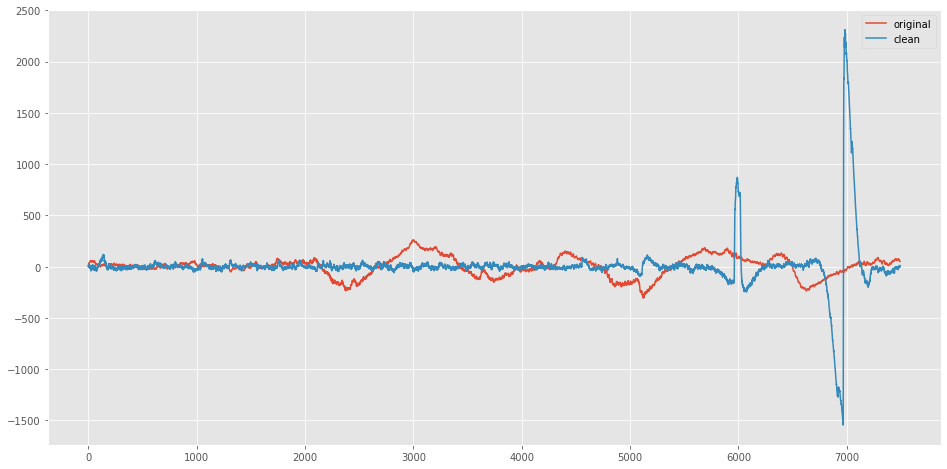

Creating RawArray with float64 data, n_channels=32, n_times=7494
    Range : 0 ... 7493 =      0.000 ...    29.972 secs
Ready.
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Creating RawArray with float64 data, n_channels=32, n_times=7494
    Range : 0 ... 7493 =      0.000 ...    29.972 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.
Creating RawArray wi

<ipython-input-45-987e2a262f70>:48: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(data_mne_filtered)


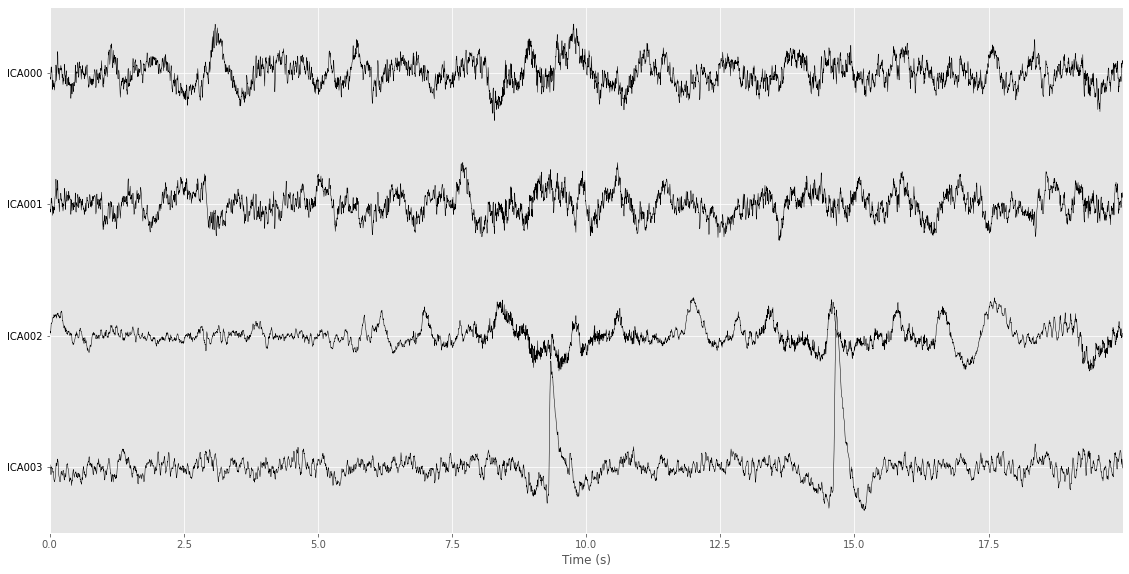

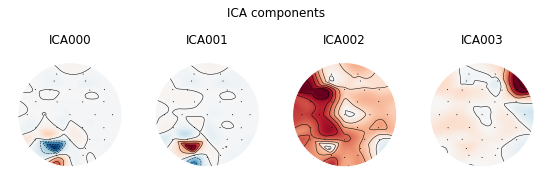

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


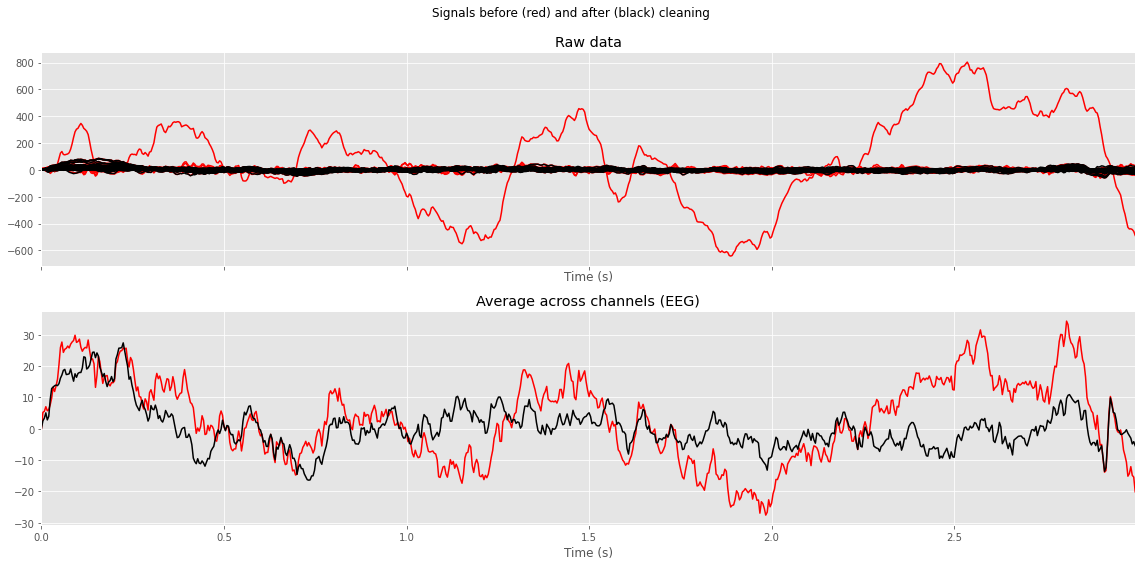

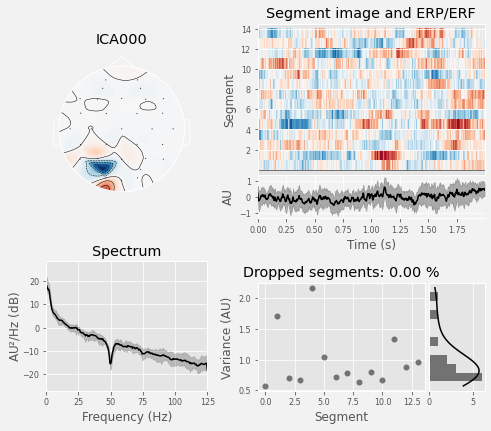

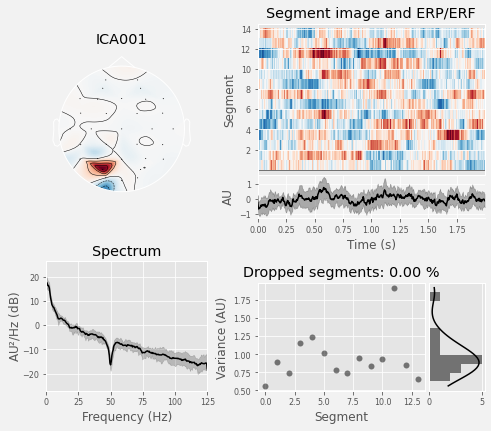

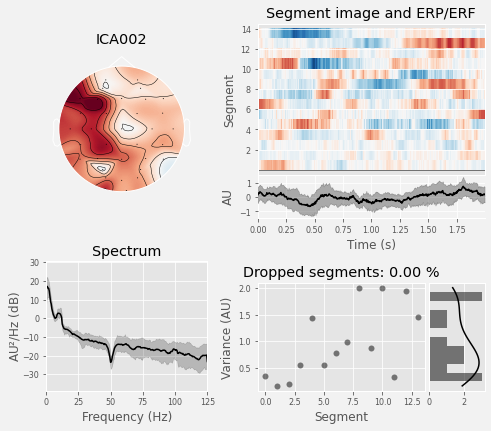

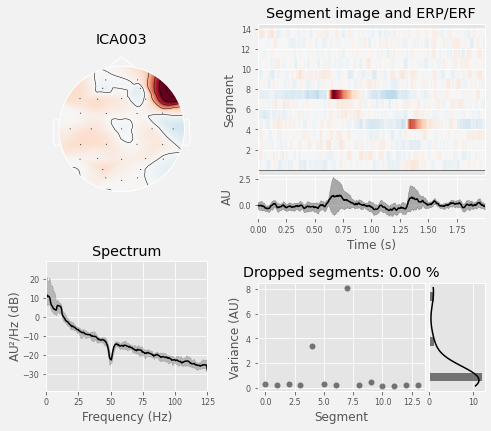

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


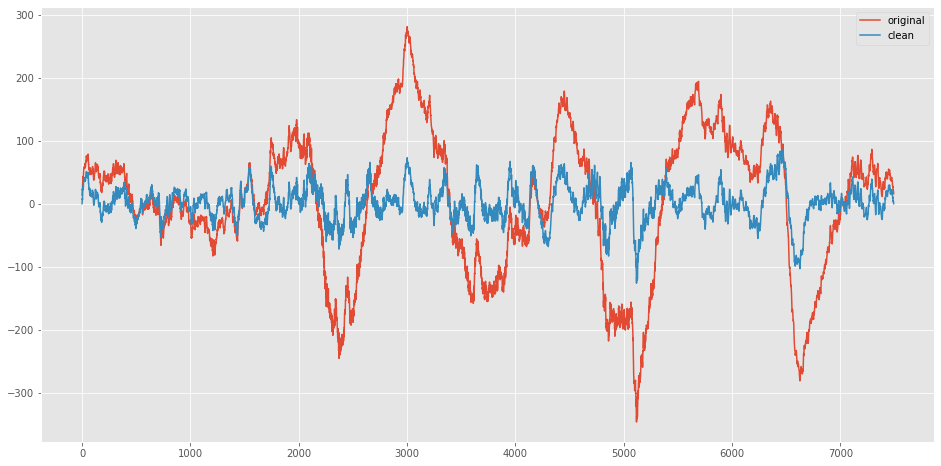

In [45]:
fname = r"./data/EEG/EEG_996_LORGIU_3.mat"

f = h5py.File(fname,'r')
data = f.get('y')
data = np.array(data)
# col 0 is the time, sampled at 250 samples per second
# col -1 is all 11, we'll drop it
# col -2 is the trigger
data = data[:, 1:-1]
data[:, -1] -= 1 #useful for sign changes


signchange = ((np.roll(data[:, -1], 1) - data[:, -1]) != 0).astype(int)
trig = np.where(signchange == 1)[0]
trig_coupled = np.array([(trig[i], trig[i+1]) for i in range(0,len(trig)-1,2)])
start_1 = trig_coupled[0][0]
stop_1 = trig_coupled[0][1]
data_trim = data[start_1:stop_1, :-1]


n_channels = 32 #32 channels
s_freq= 250 #250 sample per second
ch_types = ['eeg'] * n_channels

montage = mne.channels.make_standard_montage('biosemi32')
data_info = mne.create_info(ch_names= montage.ch_names, sfreq=s_freq, ch_types=ch_types, verbose=True) 

data_mne_raw = mne.io.RawArray(data_trim.T, data_info)
data_mne_raw._filenames = [fname.split('/')[-1]]

data_filtered = mne.filter.filter_data(data_trim.T, s_freq, l_freq=1.0, h_freq=None, picks=None)

data_mne_filtered = mne.io.RawArray(data_filtered, data_info)                    
data_mne_filtered._filenames = [fname.split('/')[-1]]
# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in data_mne_filtered.ch_names)
data_mne_filtered.rename_channels(new_names)


data_mne_filtered.set_montage(montage)
data_mne_filtered.set_eeg_reference(projection=True)  # needed for inverse modeling


ica = ICA(n_components=4, max_iter='auto', random_state=97)
ica.fit(data_mne_filtered)



ica.plot_sources(data_mne_filtered, show_scrollbars=False)
ica.plot_components(ch_type='eeg')
ica.plot_overlay(data_mne_filtered, exclude=[0,1], picks='eeg')
ica.plot_properties(data_mne_filtered, verbose=False)


clean = data_mne_filtered.get_data()
ica.apply(data_mne_filtered)
plt.plot(data_trim[:, 5], label='original')
plt.plot(clean[5, :], label='clean')
plt.legend()

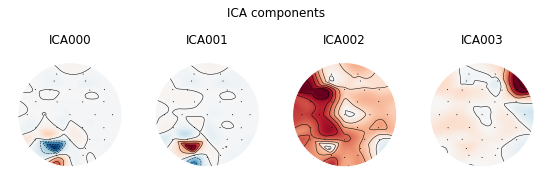

[<MNEFigure size 561.6x187.56 with 4 Axes>]

In [42]:

ica.plot_components(ch_type='eeg')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)  # set view angle
ten_twenty_montage.plot(kind='topomap', show_names=True)